In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.classification import DecisionTreeClassifier, OneVsRest
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.functions import col, when

from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler


spark = SparkSession.builder \
    .master("local") \
    .appName("DecisionTree") \
    .getOrCreate()

In [2]:
# load the dataset
data = spark.read.csv("GROUP2.csv.gz", header=True, sep=',',inferSchema="true")
#renaming winPlaceClass with label
data = data.withColumnRenamed('winPlaceClass', 'label')
data.printSchema()

root
 |-- groupId: string (nullable = true)
 |-- matchId: string (nullable = true)
 |-- matchDuration: integer (nullable = true)
 |-- label: integer (nullable = true)
 |-- isFirstPerson: boolean (nullable = true)
 |-- matchtype: integer (nullable = true)
 |-- maxPlace: integer (nullable = true)
 |-- numGroups: integer (nullable = true)
 |-- hasDisconnected: integer (nullable = true)
 |-- assist_SUM: integer (nullable = true)
 |-- assist_MAX: integer (nullable = true)
 |-- assist_AVG: integer (nullable = true)
 |-- heals_SUM: integer (nullable = true)
 |-- heals_MAX: integer (nullable = true)
 |-- heals_AVG: integer (nullable = true)
 |-- kills_SUM: integer (nullable = true)
 |-- kills_MAX: integer (nullable = true)
 |-- kills_AVG: integer (nullable = true)
 |-- headshotKills_SUM: integer (nullable = true)
 |-- headshotKills_MAX: integer (nullable = true)
 |-- headshotKills_AVG: integer (nullable = true)
 |-- killStreaks_MAX: integer (nullable = true)
 |-- roadKills_SUM: integer (nullab

In [3]:
inputCols =  data.columns

toRemove = ['matchId', 'groupId', 'killPlace_MAX', 'rankPoints_MAX', 'killPoints_MAX', 'winPoints_MAX', 'label']
inputCols = list(set(inputCols) - set(toRemove))

In [5]:
assembler = VectorAssembler(
    inputCols=inputCols,
    outputCol="features")

output = assembler.transform(data)

In [6]:
seed = 42
withReplacement=False
output = output.sample(withReplacement, 0.5, seed).select("features", "label")

(training,testing) = output.randomSplit([0.7,0.3])
print(F'training: {training.count()}')
print(F'testing: {testing.count()}')

training: 705594
testing: 302933


In [7]:
training.groupBy('label').count().toPandas()

,label,count
0,1,16394
1,6,16576
2,3,165246
3,5,167994
4,4,174094
5,2,165290


## GridSearch

paramGrid = ParamGridBuilder() \
    .addGrid(dt.maxDepth, range(3, 20)) \
    .addGrid(dt.minInstancesPerNode, range(5, 50)) \
    .addGrid(dt.impurity, ['gini','entropy']) \ 
    .addGrid(dt.minInfoGain, range(0.0, 0.1)) \
    .addGrid(dt.maxBins, range(8, 512)) \
    .build()

In [8]:
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features", impurity="gini", seed=42)

paramGrid = ParamGridBuilder() .addGrid(dt.maxDepth, [11, 12, 13])  \
    .addGrid(dt.minInstancesPerNode, [50]) \
    .addGrid(dt.impurity, ['entropy']) \
    .addGrid(dt.minInfoGain, [0.0]) \
    .addGrid(dt.maxBins, [256, 384, 512]) \
    .build()

crossval = CrossValidator(estimator=dt,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3) 

cvModel = crossval.fit(training)

In [9]:
# Best parameters
print(cvModel.getEstimatorParamMaps()[np.argmax(cvModel.avgMetrics)])
print(np.max(cvModel.avgMetrics))

{Param(parent='DecisionTreeClassifier_67c62ef6fd81', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 13, Param(parent='DecisionTreeClassifier_67c62ef6fd81', name='minInstancesPerNode', doc='Minimum number of instances each child must have after split. If a split causes the left or right child to have fewer than minInstancesPerNode, the split will be discarded as invalid. Should be >= 1.'): 50, Param(parent='DecisionTreeClassifier_67c62ef6fd81', name='impurity', doc='Criterion used for information gain calculation (case-insensitive). Supported options: entropy, gini'): 'entropy', Param(parent='DecisionTreeClassifier_67c62ef6fd81', name='minInfoGain', doc='Minimum information gain for a split to be considered at a tree node.'): 0.0, Param(parent='DecisionTreeClassifier_67c62ef6fd81', name='maxBins', doc='Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categorie

In [10]:
model = cvModel.bestModel

------------------------------

Once the parameters have been identified, training is carried out on the entire dataset

In [20]:
assembler = VectorAssembler(
    inputCols=inputCols,
    outputCol="features")

output = assembler.transform(data)

(training,testing) = output.select("features", "label").randomSplit([0.7,0.3], seed=42)
print(F'training: {training.count()}')
print(F'testing: {testing.count()}')

training: 1410431
testing: 603659


In [21]:
dt = DecisionTreeClassifier(maxDepth=11, labelCol="label",
                            featuresCol="features", impurity="entropy",
                            minInstancesPerNode=50, minInfoGain=0.0,
                            maxBins=256, seed=42)
model = dt.fit(training)

In [22]:
predictions = model.transform(testing)
predictions.show(5)

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|(51,[0,1,2,3,4,5,...|    5|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|       5.0|
|(51,[0,1,2,3,4,5,...|    5|[0.0,0.0,0.0,4.0,...|[0.0,0.0,0.0,0.01...|       4.0|
|(51,[0,1,2,3,4,5,...|    4|[0.0,0.0,0.0,2.0,...|[0.0,0.0,0.0,4.62...|       5.0|
|(51,[0,1,2,3,4,5,...|    5|[0.0,5.0,0.0,0.0,...|[0.0,0.0022675736...|       5.0|
|(51,[0,1,2,3,4,5,...|    5|[0.0,5.0,0.0,0.0,...|[0.0,0.0022675736...|       5.0|
+--------------------+-----+--------------------+--------------------+----------+
only showing top 5 rows



In [23]:
features_importances = pd.Series(model.featureImportances.toArray(), index=inputCols)
features_importances.nlargest(20)

walkDistance_AVG       0.592457
walkDistance_MAX       0.122651
numGroups              0.055988
matchDuration          0.049526
hasDisconnected        0.041049
distance_AVG           0.029777
kills_AVG              0.027058
distance_MAX           0.023070
maxPlace               0.018805
kills_SUM              0.010429
heals_AVG              0.005430
damageDealt_AVG        0.004424
weaponsAcquired_SUM    0.002580
weaponsAcquired_AVG    0.002484
heals_MAX              0.002216
isFirstPerson          0.002077
damageDealt_MAX        0.001778
rideDistance_AVG       0.001627
walkDistance_SUM       0.001165
weaponsAcquired_MAX    0.000895
dtype: float64

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


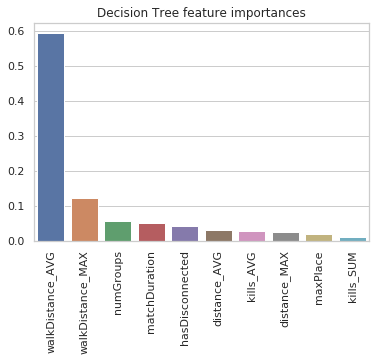

In [24]:
# display
sns.set_theme(style="whitegrid")
ax = sns.barplot(features_importances.nlargest(10).index, features_importances.nlargest(10).values)
ax.tick_params(axis='x', rotation=90)
plt.title("Decision Tree feature importances")
plt.savefig('feature_importance_dt.pdf', bbox_inches='tight')
plt.show()

In [25]:
print(model.toDebugString)

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_f7ed521e00c3, depth=11, numNodes=1653, numClasses=7, numFeatures=51
  If (feature 38 <= 740.95)
   If (feature 38 <= 167.9875)
    If (feature 6 <= 0.5)
     If (feature 8 <= 64.91125)
      If (feature 45 <= 36.5)
       If (feature 38 <= 28.1875)
        If (feature 8 <= 11.975000000000001)
         If (feature 49 <= 3.5)
          Predict: 1.0
         Else (feature 49 > 3.5)
          If (feature 2 <= 0.5)
           If (feature 46 <= 10.985)
            If (feature 4 <= 2.5E-5)
             Predict: 6.0
            Else (feature 4 > 2.5E-5)
             Predict: 5.0
           Else (feature 46 > 10.985)
            Predict: 6.0
          Else (feature 2 > 0.5)
           Predict: 6.0
        Else (feature 8 > 11.975000000000001)
         If (feature 23 <= 0.5)
          If (feature 46 <= 26.525)
           If (feature 8 <= 14.372250000000001)
            Predict: 6.0
           Else (feature 8 > 14.372250000000001)
      

## Evaluation

In [26]:
from pyspark.mllib.evaluation import MulticlassMetrics

predictionAndLabels = predictions.rdd.map(lambda x: (x.prediction, float(x.label)))
metrics = MulticlassMetrics(predictionAndLabels)

In [27]:
# Summary stats
print("Recall = %s" % metrics.weightedRecall)
print("Precision = %s" % metrics.weightedPrecision)
print("F1 measure = %s" % metrics.weightedFMeasure())
print("Accuracy = %s" % metrics.accuracy)

# Individual label stats
labels = [1.0, 2.0 ,3.0, 4.0, 5.0, 6.0]
for label in labels:
    print("Class %s precision = %s" % (label, metrics.precision(label)))
    print("Class %s recall = %s" % (label, metrics.recall(label)))
    print("Class %s F1 Measure = %s" % (label, metrics.fMeasure(label)))
    
print('Confusion Matrix')
print(metrics.confusionMatrix().toArray())

Recall = 0.7206618306030391
Precision = 0.7189430636819862
F1 measure = 0.7173131294960977
Accuracy = 0.7206618306030391
Class 1.0 precision = 0.6409817351598174
Class 1.0 recall = 0.23947967017344327
Class 1.0 F1 Measure = 0.3486855723452701
Class 2.0 precision = 0.7401864523782397
Class 2.0 recall = 0.7799340409454601
Class 2.0 F1 Measure = 0.759540593514666
Class 3.0 precision = 0.6419033918944902
Class 3.0 recall = 0.6396258949923007
Class 3.0 F1 Measure = 0.6407626196924783
Class 4.0 precision = 0.6947240840331682
Class 4.0 recall = 0.7031721345542788
Class 4.0 F1 Measure = 0.6989225818058248
Class 5.0 precision = 0.8046892597522269
Class 5.0 recall = 0.8206479367377625
Class 5.0 F1 Measure = 0.8125902516189288
Class 6.0 precision = 0.7358156028368794
Class 6.0 recall = 0.5830698981383913
Class 6.0 F1 Measure = 0.6505976876347247
Confusion Matrix
[[3.36900e+03 1.03220e+04 3.28000e+02 7.00000e+00 1.10000e+01 3.10000e+01]
 [1.83600e+03 1.10441e+05 2.83080e+04 9.77000e+02 4.00000e+01

In [28]:
from sklearn.metrics import classification_report, confusion_matrix

In [29]:
y_true = predictions.select(['label']).collect()
y_pred = predictions.select(['prediction']).collect()

In [30]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           1       0.64      0.24      0.35     14068
           2       0.74      0.78      0.76    141603
           3       0.64      0.64      0.64    140923
           4       0.69      0.70      0.70    149174
           5       0.80      0.82      0.81    143656
           6       0.74      0.58      0.65     14235

    accuracy                           0.72    603659
   macro avg       0.71      0.63      0.65    603659
weighted avg       0.72      0.72      0.72    603659



In [31]:
print(confusion_matrix(y_true, y_pred))

[[  3369  10322    328      7     11     31]
 [  1836 110441  28308    977     40      1]
 [    48  27886  90138  22377    452     22]
 [     0    555  21487 104895  22192     45]
 [     0      3    161  22720 117891   2881]
 [     3      0      1     12   5919   8300]]


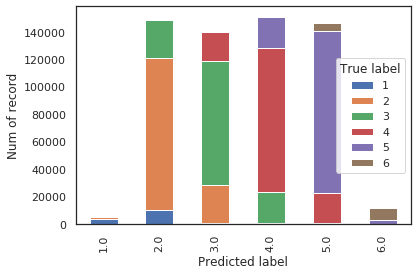

In [32]:
cross_tab = predictions.crosstab('prediction', 'label').toPandas().sort_values(by=["prediction_label"]).set_index('prediction_label')
sns.set_style('white')
cross_tab.plot.bar(stacked=True)

plt.ylabel("Num of record")
plt.xlabel("Predicted label")
plt.legend(title="True label")

plt.savefig("confMatrixGraph_DT.pdf", bbox_inches='tight')

In [33]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Note that due to returning the created figure object, when this funciton is called in a
    notebook the figure willl be printed twice. To prevent this, either append ; to your
    function call, or modify the function by commenting out the return expression.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d",cmap=plt.cm.Blues)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    # Note that due to returning the created figure object, when this funciton is called in a notebook
    # the figure willl be printed twice. To prevent this, either append ; to your function call, or
    # modify the function by commenting out this return expression.
    #return fig

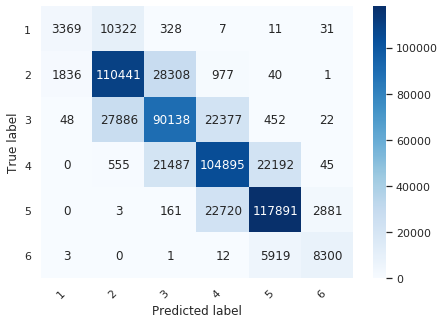

In [34]:
cf_matrix = confusion_matrix(y_true, y_pred)
print_confusion_matrix(cf_matrix, class_names=['1','2','3','4','5','6'],figsize = (7,5), fontsize=11)

---------------------------------------------

try removing the distance attributes from the training set

In [24]:
inputCols =  data.columns

toRemove = ['matchId', 'groupId', 'killPlace_MAX', 'rankPoints_MAX', 'killPoints_MAX', 'winPoints_MAX', 'label']
toRemove = toRemove + ['walkDistance_SUM', 'walkDistance_MAX', 'walkDistance_AVG', 'distance_SUM', 'distance_AVG', 'distance_MAX']
inputCols = list(set(inputCols) - set(toRemove))

In [25]:
assembler = VectorAssembler(
    inputCols=inputCols,
    outputCol="features")

output = assembler.transform(data)

In [26]:
(training,testing) = output.randomSplit([0.7,0.3])
print(F'training: {training.count()}')
print(F'testing: {testing.count()}')

training: 1407905
testing: 606185


In [27]:
dt = DecisionTreeClassifier(maxDepth=11, labelCol="label",
                            featuresCol="features", impurity="entropy",
                            minInstancesPerNode=50, minInfoGain=0.0,
                            maxBins=256, seed=42)
model = dt.fit(training)

In [28]:
predictions = model.transform(testing)
predictions.show(5)

+--------------+--------------+-------------+-----+-------------+---------+--------+---------+---------------+----------+----------+----------+---------+---------+---------+---------+---------+---------+-----------------+-----------------+-----------------+---------------+-------------+-------------+-------------+---------------+-------------------+-------------------+-------------------+-------------------+------------------+---------------+------------------+------------------+------------+------------------+----------------+----------------+----------------+------------------+----------------+------------------+----------------+----------------+------------------+---------+---------+---------+-----------+-----------+-----------+-------------+-------------+-------------+-------------+--------------+--------------+-------------+--------------------+--------------------+--------------------+----------+
|       groupId|       matchId|matchDuration|label|isFirstPerson|matchtype|maxPlace|

In [29]:
predictionAndLabels = predictions.rdd.map(lambda x: (x.prediction, float(x.label)))
metrics = MulticlassMetrics(predictionAndLabels)
# Summary stats
print("Recall = %s" % metrics.weightedRecall)
print("Precision = %s" % metrics.weightedPrecision)
print("F1 measure = %s" % metrics.weightedFMeasure())
print("Accuracy = %s" % metrics.accuracy)

# Individual label stats
labels = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0]
for label in labels:
    print("Class %s precision = %s" % (label, metrics.precision(label)))
    print("Class %s recall = %s" % (label, metrics.recall(label)))
    print("Class %s F1 Measure = %s" % (label, metrics.fMeasure(label)))
    
print('Confusion Matrix')
print(metrics.confusionMatrix().toArray())

Recall = 0.5804597606341297
Precision = 0.5781886622956028
F1 measure = 0.57644179390633
Accuracy = 0.5804597606341299
Class 1.0 precision = 0.6158966327329679
Class 1.0 recall = 0.22147131291798663
Class 1.0 F1 Measure = 0.3257909180344845
Class 2.0 precision = 0.6091552909781381
Class 2.0 recall = 0.6303592038462356
Class 2.0 F1 Measure = 0.6195758836916353
Class 3.0 precision = 0.4692900884554321
Class 3.0 recall = 0.43715843146092737
Class 3.0 F1 Measure = 0.4526547607761921
Class 4.0 precision = 0.5112583793281259
Class 4.0 recall = 0.5364621951463898
Class 4.0 F1 Measure = 0.5235571375486495
Class 5.0 precision = 0.7110813849792563
Class 5.0 recall = 0.7600027627171323
Class 5.0 F1 Measure = 0.7347286257515916
Class 6.0 precision = 0.6715591248961507
Class 6.0 recall = 0.50977506832037
Class 6.0 F1 Measure = 0.5795889101338432
Confusion Matrix
[[3.14600e+03 1.04140e+04 4.90000e+02 1.37000e+02 1.10000e+01 7.00000e+00]
 [1.81000e+03 8.90250e+04 3.86540e+04 1.10940e+04 6.40000e+02 6

In [30]:
features_importances = pd.Series(model.featureImportances.toArray(), index=inputCols)
features_importances.nlargest(20)

weaponsAcquired_AVG    0.503510
heals_AVG              0.133509
hasDisconnected        0.095014
longestKill_MAX        0.046764
kills_MAX              0.045527
matchDuration          0.036674
rideDistance_AVG       0.034565
kills_SUM              0.017311
swimDistance_AVG       0.016545
numGroups              0.013670
maxPlace               0.012324
heals_MAX              0.011103
rideDistance_SUM       0.008045
kills_AVG              0.007058
damageDealt_AVG        0.005492
weaponsAcquired_MAX    0.002847
matchtype              0.002449
DBNOs_SUM              0.002255
rideDistance_MAX       0.001806
weaponsAcquired_SUM    0.000733
dtype: float64

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


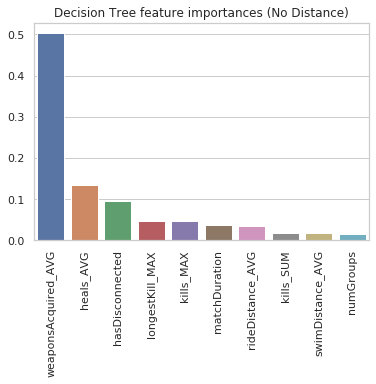

In [31]:
# display
sns.set_theme(style="whitegrid")
ax = sns.barplot(features_importances.nlargest(10).index, features_importances.nlargest(10).values)
ax.tick_params(axis='x', rotation=90)
plt.title("Decision Tree feature importances (No Distance)")
plt.savefig('feature_importance_dt_noDistance.pdf', bbox_inches='tight')
plt.show()

In [32]:
y_true = predictions.select(['label']).collect()
y_pred = predictions.select(['prediction']).collect()

In [33]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           1       0.62      0.22      0.33     14205
           2       0.61      0.63      0.62    141229
           3       0.47      0.44      0.45    141992
           4       0.51      0.54      0.52    149703
           5       0.71      0.76      0.73    144785
           6       0.67      0.51      0.58     14271

    accuracy                           0.58    606185
   macro avg       0.60      0.52      0.54    606185
weighted avg       0.58      0.58      0.58    606185



In [34]:
spark.stop()